# Point source recovery for a small small image

In [1]:
import numpy as onp
import jax.numpy as jnp

In [2]:
import jax

In [3]:
from jaxri import lnprob, priors

In [4]:
from matplotlib import pyplot as plt

In [5]:
from jax.experimental import optimizers

In [6]:
import jax.scipy as jsp

In [7]:
ground_truth = onp.zeros((10, 10))
ground_truth[4, 5] = 5

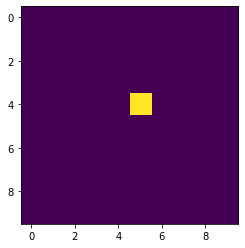

In [8]:
plt.imshow(ground_truth)

In [9]:
uv_arr = jnp.asarray(onp.loadtxt('../test-data/random_baselines.csv', delimiter=',')) * 50
model_im = jnp.asarray(ground_truth)
lm_arr = jnp.indices(model_im.shape)
vis_obs = jnp.asarray(lnprob.simulate(uv_arr, lm_arr, model_im, sigma=1))

In [10]:
uv_arr = jax.device_put(uv_arr)
lm_arr = jax.device_put(lm_arr)
vis_obs = jax.device_put(vis_obs)

In [11]:
def loss(im):
    return - jnp.sum((priors.ln_positive_number(im) + lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1)))

In [12]:
def like(im):
    return -lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1)

In [13]:
from jax.experimental import optimizers

In [14]:
rng = jax.random.PRNGKey(65)
init_params = jax.random.normal(rng, shape=(10, 10)) * 0.01 + 1

In [184]:
init_fun, update_fun, get_params = optimizers.sgd(1e-4)
opt_state = init_fun(init_params)

In [185]:
def update(step, opt_state):
    value, grads = jax.value_and_grad(like)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state

In [186]:
j_update = jax.jit(update)

In [189]:
loss_list = []
opt_state = init_fun(init_params)
for step in range(50000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

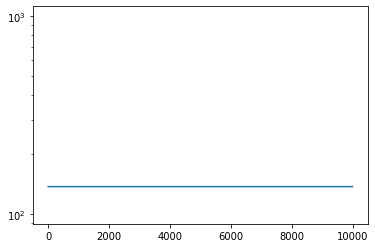

In [226]:
plt.plot(loss_list[-10000:])
plt.yscale('log')

In [15]:
def compute_i(uv: jnp.array, lm: jnp.array, vis: jnp.array):
    l, m = lm
    u, v = uv
    return jnp.sum(vis * jnp.exp(2 * jnp.pi * 1j * (u * l + v * m)))

vmapped_compute_i = jax.vmap(compute_i, in_axes=(None, 0, None))

In [201]:
lm_arr.reshape(2, 100).T.shape

(100, 2)

In [205]:
uv_arr.shape

(100, 2)

In [59]:
im_dft = vmapped_compute_i(uv_arr.T, lm_arr.reshape(2, 100).T, vis_obs)

In [60]:
im_dft.max()

DeviceArray(504.08362-2.14226j, dtype=complex64)

Note that for iDFT - I need to scale the output by 1/N where N is the total number of pixels.

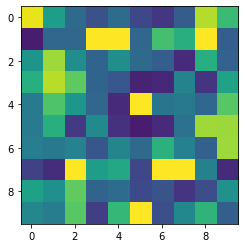

In [225]:
plt.imshow(jnp.abs(im_dft).reshape(10, 10) / abs(im_dft).max(), vmin=0., vmax=0.2)

In [214]:
abs(im_dft).max()

DeviceArray(524.10236, dtype=float32)

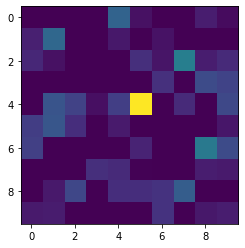

In [223]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

# Now include the prior
It looks like the gradient blows up pretty easily with SGD. But Adam seems to handle it nicely.

In [22]:
init_fun, update_fun, get_params = optimizers.adam(1e-4)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(loss)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state

In [23]:
j_update = jax.jit(update)

In [35]:
loss_list = []
opt_state = init_fun(init_params)
for step in range(50000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

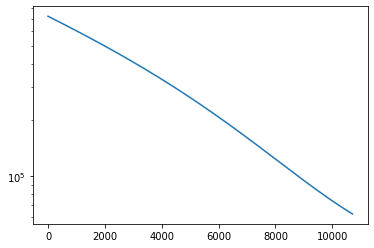

In [36]:
plt.plot(loss_list)
plt.yscale('log')

In [37]:
loss_list[-1]

DeviceArray(inf, dtype=float32)

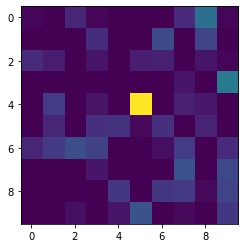

In [38]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

...the cost became inf but somehow the gradient is still there after ~12000 steps...? The image looks quite a bit worse at 12000 than it does at 50000. Oh I have (small) negative values in the pixel that's why the cost goes inf...

In practice, to enforce a prior that the pixels must be positive, we might want to do a RELU type distribution for the prior where it gets very steep for input < 0.

In [39]:
loss(get_params(opt_state))

DeviceArray(inf, dtype=float32)

# Adam on the likelihood

In [41]:
init_fun, update_fun, get_params = optimizers.adam(1e-4)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(like)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state
j_update = jax.jit(update)
loss_list = []
opt_state = init_fun(init_params)
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

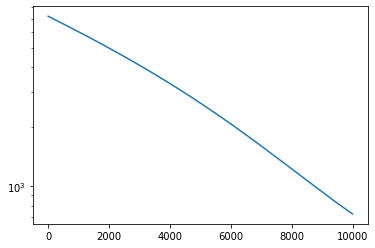

In [42]:
plt.plot(loss_list)
plt.yscale('log')

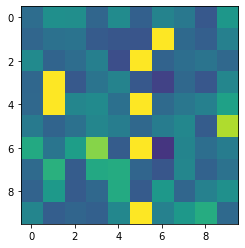

In [43]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

In [44]:
for step in range(20000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

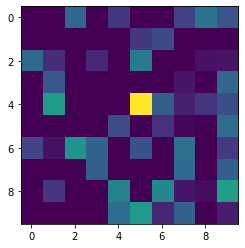

In [45]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

In [46]:
for step in range(20000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

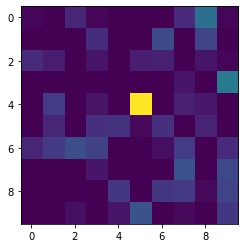

In [47]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

In [48]:
for step in range(20000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

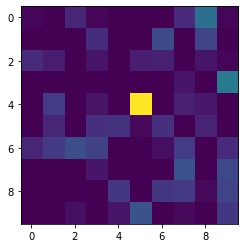

In [49]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

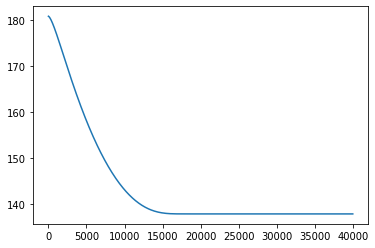

In [52]:
plt.plot(loss_list[-40000:])

Looks like the loss function is at a good place after ~45000 steps. Try higher step size?

In [53]:
init_fun, update_fun, get_params = optimizers.adam(1e-3)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(like)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state
j_update = jax.jit(update)
loss_list = []
opt_state = init_fun(init_params)
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

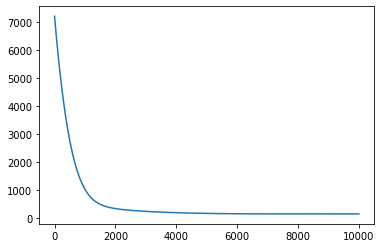

In [55]:
plt.plot(loss_list)

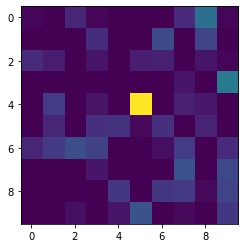

In [56]:
plt.imshow(get_params(opt_state) / get_params(opt_state).max(), vmin=0, vmax=0.2)

In [7]:
def generate_point_source_im(imsize, peak_i, peak_j):
    ground_truth = onp.zeros((imsize, imsize))
    ground_truth[peak_i, peak_j] = 5
    return ground_truth

# Now try for a 500x500 point source

In [8]:
ground_truth = generate_point_source_im(500, 254, 267)

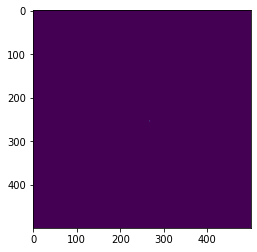

In [9]:
plt.imshow(ground_truth)

In [23]:
def prior(im):
    return jsp.stats.norm.logpdf(im, loc=0, scale=4)

In [10]:
uv_arr = jnp.asarray(onp.loadtxt('../test-data/random_baselines.csv', delimiter=','))
model_im = jnp.asarray(ground_truth)
lm_arr = jnp.indices(model_im.shape)
vis_obs = jnp.asarray(lnprob.simulate(uv_arr, lm_arr, model_im, sigma=1))
uv_arr = jax.device_put(uv_arr)
lm_arr = jax.device_put(lm_arr)
vis_obs = jax.device_put(vis_obs)

def like(im):
    return -lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1)

In [27]:
def loss(im):
    return - (jnp.sum(prior(im)) + lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1))

In [50]:
rng = jax.random.PRNGKey(65)
init_params = jax.random.normal(rng, shape=(500, 500)) * 1

In [51]:
init_fun, update_fun, get_params = optimizers.adam(1e-2)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(loss)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state
j_update = jax.jit(update)
loss_list = []
opt_state = init_fun(init_params)
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

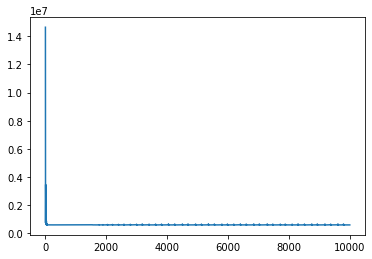

In [52]:
plt.plot(loss_list)

In [54]:
loss_list[400]

DeviceArray(584186.8, dtype=float32)

In [44]:
loss_list[5000]

DeviceArray(584065.44, dtype=float32)

In [45]:
loss_list[-2]

DeviceArray(583395., dtype=float32)

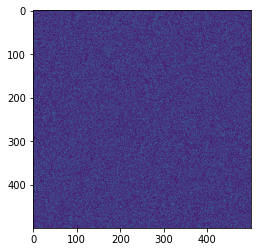

In [46]:
plt.imshow(jnp.abs(get_params(opt_state)))

In [47]:
jnp.abs(get_params(opt_state)).max()

DeviceArray(4.621981, dtype=float32)

In [49]:
jnp.unravel_index(jnp.argmax(jnp.abs(get_params(opt_state))), get_params(opt_state).shape)

(466, 295)

ok this is too difficult for 500x500 image and 100 measurements. Let me switch to 50x50.
# Now try for a 50x50 point source

In [8]:
ground_truth = generate_point_source_im(50, 27, 18) * 2

uv_arr = jnp.asarray(onp.loadtxt('../test-data/random_baselines.csv', delimiter=',')) * 10
model_im = jnp.asarray(ground_truth)
lm_arr = jnp.indices(model_im.shape)
vis_obs = jnp.asarray(lnprob.simulate(uv_arr, lm_arr, model_im, sigma=1))
uv_arr = jax.device_put(uv_arr)
lm_arr = jax.device_put(lm_arr)
vis_obs = jax.device_put(vis_obs)
def prior(im):
    return jsp.stats.norm.logpdf(im, loc=0, scale=4)
def like(im):
    return -lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1)
def loss(im):
    return - (jnp.sum(prior(im)) + lnprob.lnprob(vis_obs, im, lm_arr, uv_arr, 1))

In [9]:
rng = jax.random.PRNGKey(65)
init_params = jax.random.normal(rng, shape=(50, 50)) * 1
init_fun, update_fun, get_params = optimizers.adam(1e-3)
opt_state = init_fun(init_params)
def update(step, opt_state):
    value, grads = jax.value_and_grad(loss)(get_params(opt_state))
    opt_state = update_fun(step, grads, opt_state)
    return value, opt_state
j_update = jax.jit(update)
loss_list = []
opt_state = init_fun(init_params)
for step in range(10000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

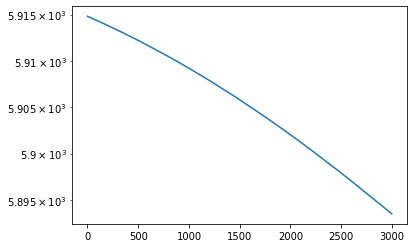

In [10]:
plt.plot(loss_list[-3000:])
plt.yscale('log')

In [11]:
for step in range(20000):
    value, opt_state = j_update(step, opt_state)
    loss_list.append(value)

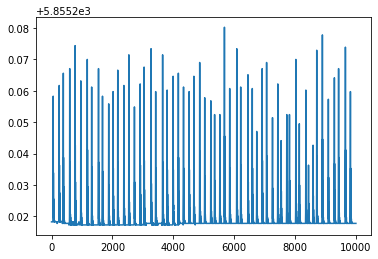

In [12]:
plt.plot(loss_list[-10000:])

In [13]:
jax.value_and_grad(loss)(ground_truth)

(DeviceArray(5949.185, dtype=float32),
 DeviceArray([[  8.435177  ,   2.0651886 ,   0.46667123, ...,
                -9.359461  , -15.571135  ,   5.457634  ],
              [  4.08894   , -10.450319  ,  15.256324  , ...,
                -0.5865178 ,  -9.065077  , -12.215027  ],
              [ -6.1016755 , -11.058706  ,   6.6802626 , ...,
               -12.906034  ,  -7.848909  ,  -3.2227316 ],
              ...,
              [-18.578733  ,   7.1721306 , -20.647131  , ...,
                14.96106   ,  -3.2603803 ,  -5.967396  ],
              [-20.039719  ,  -1.3570628 ,   3.8425083 , ...,
                15.889267  ,  18.739866  ,   5.872913  ],
              [ 13.854609  ,   8.799249  ,  -1.8130369 , ...,
               -19.346478  ,  -7.9333377 ,   2.9459877 ]], dtype=float32))

In [28]:
im_dft = jnp.abs(vmapped_compute_i(uv_arr.T, lm_arr.reshape(2, 50*50).T, vis_obs))

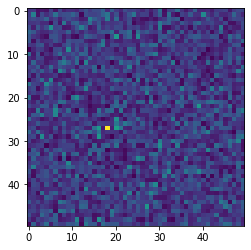

In [37]:
plt.imshow((im_dft / im_dft.max()).reshape(50, 50), vmin=0, vmax=0.5)

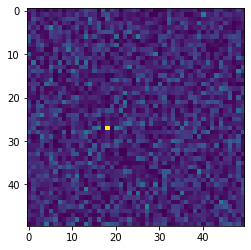

In [36]:
plt.imshow(jnp.abs(get_params(opt_state))/jnp.abs(get_params(opt_state)).max(), vmin=0, vmax=0.5)

In [14]:
jnp.abs(get_params(opt_state)).max()

DeviceArray(3.1869268, dtype=float32)